# POS Tagging with Word Embeddings

This notebook shows the task os part-of-speech (POS) tagging using word embeddings and a multi-layer perceptron. POS is a category of words that have similar grammatical properties, such as nouns, verbs, adjectives etc. POS tagging is considered to be the basic type of linguistic analysis of text.

Note that the running this notebook requires downloading gigabytes of data. (Note for the instructors: load the embeddings and the corpora in advance, so you don't have to wait minutes until they load.)

In [1]:
import numpy as np
import fasttext
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

First we, download word embeddings. We use [FastText](https://fasttext.cc/), which is an extension of the skip-gram model that we saw in the lecture. The main difference is that embeddings of less frequent words are obtained as a sum of embeddings of their substrings. In this way, it leads to better quality embeddings for less frequent words and better capture complex morphology.

In [2]:
import os

if os.path.exists('cc.cs.300.bin') and os.path.exists('cc.en.300.bin'):
    print('FastText models already downloaded.')
else:
    ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.cs.300.bin.gz
    ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    ! gunzip cc.cs.300.bin.gz
    ! gunzip cc.en.300.bin.gz

FastText models already downloaded.


For training and testing our taggers, we will use Universal Dependencies corpora: a collection of texts with morphological and syntactic analysis for over 150 languages. In our experiments, we will use English and Czech.

We will download the entire set of datasets as a tarball and load the individual corpora directly from the tarball file.

In [3]:
if os.path.exists('ud-treebanks-v2.14.tgz'):
    print('UD Treebanks already downloaded.')
else:
    ! curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-5502/ud-treebanks-v2.14.tgz

UD Treebanks already downloaded.


Universal Dependencies use a tab-separated format for the data. Every sentences in the dataset looks like this:

```
# sent_id = weblog-blogspot.com_marketview_20050511222700_ENG_20050511_222700-0006
# text = Is that a money maker?
1       Is      be      AUX     VBZ     Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin   5       cop     5:cop   _
2       that    that    PRON    DT      Number=Sing|PronType=Dem        5       nsubj   5:nsubj _
3       a       a       DET     DT      Definite=Ind|PronType=Art       5       det     5:det   _
4       money   money   NOUN    NN      Number=Sing     5       compound        5:compound      _
5       maker   maker   NOUN    NN      Number=Sing     0       root    0:root  SpaceAfter=No
6       ?       ?       PUNCT   .       _       5       punct   5:punct _
```

The second columns is the word itself, the third columns is its lemma (the basic form of the word, such as `be` for `Is`), the third column is the part of speech that we are interested in. The rest of the columns encode syntactic structure and more finegrained morphological information.

All words are categorized into this set of POS:

 -  `ADJ`: adjective
 -  `ADP`: adposition
 -  `ADV`: adverb
 -  `AUX`: auxiliary
 -  `CCONJ`: coordinating conjunction
 -  `DET`: determiner
 -  `INTJ`: interjection
 -  `NOUN`: noun
 -  `NUM`: numeral
 -  `PART`: particle
 -  `PRON`: pronoun
 -  `PROPN`: proper noun
 -  `PUNCT`: punctuation
 -  `SCONJ`: subordinating conjunction
 -  `SYM`: symbol
 -  `VERB`: verb
 -  `X`: other


The following function reads the file like this and returns sentences as lists of words and corresponding lists of POS tags. For the purposes of this demonstration, we limit the numbers of sentences that we load.


In [4]:
import tarfile

# Here, we load the CoNLL-U data, to have a list of list of sentence tokens and a list of lists of POS tags
def load_conllu(file_name, embeddings, max_sentences=500):
    sentence_tokens = []
    sentence_tags = []
    sentence_embeddings = []

    current_sentence_tokens = []
    current_sentence_tags = []
    current_sentence_embeddings = []

    with tarfile.open("ud-treebanks-v2.14.tgz", 'r:gz') as tar:
        f_conllu = tar.extractfile(tar.getmember(file_name))
        for line in f_conllu:
            line = line.decode("utf-8")
            if line.startswith("#"):
                continue
            if line == "\n":
                sentence_tokens.append(current_sentence_tokens)
                sentence_embeddings.append(current_sentence_embeddings)
                sentence_tags.append(current_sentence_tags)
                current_sentence_tokens = []
                current_sentence_embeddings = []
                current_sentence_tags = []

                if len(sentence_tokens) == max_sentences:
                    break
            else:
                line = line.strip().split("\t")
                token = line[1]
                current_sentence_tokens.append(token)
                current_sentence_embeddings.append(embeddings.get_word_vector(token))
                current_sentence_tags.append(line[3])

    return sentence_tokens, sentence_embeddings, sentence_tags

The following function prepares concatenation of word embeddings for sliding windows of words. This means that if we set a context window of 5, word $w_k$ will be represented by embeddings of word $(w_{k-2}, w_{k-1}, w_k, w_{k+1}, w_{k+2})$ to put the word in the context.

In [5]:
zero_emb = np.zeros(300)
def sliding_window_prepare_data(embeddings, window_size):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd")
    half_window = window_size // 2

    word_count = 0
    vectors = []
    for sentence in embeddings:
        word_count += len(sentence)
        padded_sentence = [zero_emb] * half_window + sentence + [zero_emb] * half_window
        for i in range(half_window, len(padded_sentence) - half_window):
            window = padded_sentence[i - half_window:i + half_window + 1]
            vectors.append(np.concatenate(window, axis=0))
    
    assert word_count == len(vectors)
    return np.stack(vectors, axis=0)

In [6]:
def train_model(train_X, train_y, test_X, test_y):
    clf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=40, alpha=1e-4,
                        solver='sgd', verbose=10, random_state=1348,
                        activation='relu',
                        learning_rate_init=.1,
                        early_stopping=True,
                        validation_fraction=0.1,
                        n_iter_no_change=5)
    clf.fit(train_X, train_y)

    predicted_labels = clf.predict(test_X)
    report = classification_report(test_y, predicted_labels, digits=4)
    conf_matrix = confusion_matrix(test_y, predicted_labels)
    
    return clf, report, conf_matrix

## Classification of POS in English

In [7]:
print("Loading the English word embeddings")
en_embeddings = fasttext.load_model('cc.en.300.bin')
print("Loading the English traing data.")
en_train_sent, en_train_emb, en_train_tags = load_conllu("ud-treebanks-v2.14/UD_English-EWT/en_ewt-ud-train.conllu", en_embeddings, max_sentences=10000)
print("Loading the English test data.")
en_test_sent, en_test_emb, en_test_tags = load_conllu("ud-treebanks-v2.14/UD_English-EWT/en_ewt-ud-test.conllu", en_embeddings, max_sentences=500)

Loading the English word embeddings
Loading the English traing data.
Loading the English test data.


In [8]:
train_X = sliding_window_prepare_data(en_train_emb, 3)
test_X = sliding_window_prepare_data(en_test_emb, 3)

train_y = [tag for tags in en_train_tags for tag in tags]
test_y = [tag for tags in en_test_tags for tag in tags]

clf, report, conf_matrix = train_model(train_X, train_y, test_X, test_y)
print(report)

Iteration 1, loss = 0.51761416
Validation score: 0.913570
Iteration 2, loss = 0.25433449
Validation score: 0.930442
Iteration 3, loss = 0.20954926
Validation score: 0.937812
Iteration 4, loss = 0.18266518
Validation score: 0.941040
Iteration 5, loss = 0.16325730
Validation score: 0.940066
Iteration 6, loss = 0.14904136
Validation score: 0.945608
Iteration 7, loss = 0.13719862
Validation score: 0.947679
Iteration 8, loss = 0.12704455
Validation score: 0.949080
Iteration 9, loss = 0.11789464
Validation score: 0.950847
Iteration 10, loss = 0.11000654
Validation score: 0.950664
Iteration 11, loss = 0.10330640
Validation score: 0.949933
Iteration 12, loss = 0.09719259
Validation score: 0.950542
Iteration 13, loss = 0.09167428
Validation score: 0.948715
Iteration 14, loss = 0.08665588
Validation score: 0.952187
Iteration 15, loss = 0.08198153
Validation score: 0.950786
Iteration 16, loss = 0.07708987
Validation score: 0.952552
Iteration 17, loss = 0.07312248
Validation score: 0.952552
Iterat

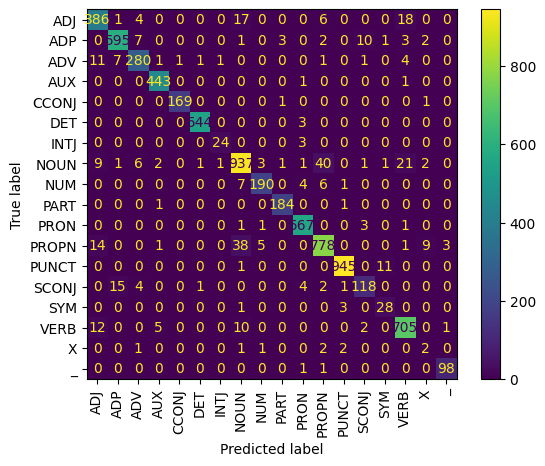

In [9]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()

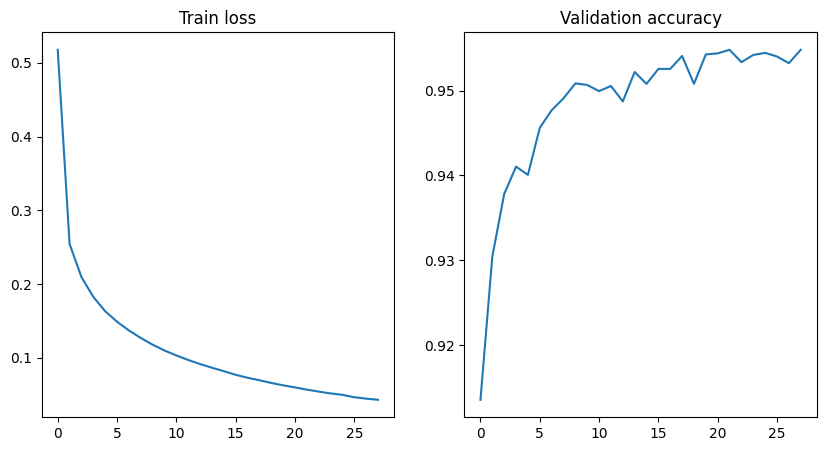

In [10]:
# A plot that is vertically separated that shows the train loss and validation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(clf.loss_curve_)
ax1.set_title('Train loss')
ax2.plot(clf.validation_scores_)
ax2.set_title('Validation accuracy')
plt.show()

## Classification of POS in Czech

In [11]:
print("Loading the Czech word embeddings")
cs_embeddings = fasttext.load_model('cc.cs.300.bin')
print("Loading the Czech training data.")
cs_train_sent, cs_train_emb, cs_train_tags = load_conllu("ud-treebanks-v2.14/UD_Czech-PDT/cs_pdt-ud-train.conllu", cs_embeddings, max_sentences=10000)
print("Loading the Czech test data.")
cs_test_sent, cs_test_emb, cs_test_tags = load_conllu("ud-treebanks-v2.14/UD_Czech-PDT/cs_pdt-ud-test.conllu", cs_embeddings, max_sentences=500)

Loading the Czech word embeddings
Loading the Czech training data.
Loading the Czech test data.


In [12]:
train_X = sliding_window_prepare_data(cs_train_emb, 3)
test_X = sliding_window_prepare_data(cs_test_emb, 3)

train_y = [tag for tags in cs_train_tags for tag in tags]
test_y = [tag for tags in cs_test_tags for tag in tags]

clf, report, conf_matrix = train_model(train_X, train_y, test_X, test_y)
print(report)

Iteration 1, loss = 0.43428216
Validation score: 0.954454
Iteration 2, loss = 0.13632453
Validation score: 0.965998
Iteration 3, loss = 0.10368549
Validation score: 0.969846
Iteration 4, loss = 0.08708154
Validation score: 0.972685
Iteration 5, loss = 0.07679163
Validation score: 0.973253
Iteration 6, loss = 0.06906079
Validation score: 0.973947
Iteration 7, loss = 0.06232385
Validation score: 0.975082
Iteration 8, loss = 0.05803829
Validation score: 0.975397
Iteration 9, loss = 0.05360670
Validation score: 0.976533
Iteration 10, loss = 0.04976137
Validation score: 0.976911
Iteration 11, loss = 0.04631504
Validation score: 0.978173
Iteration 12, loss = 0.04368568
Validation score: 0.976091
Iteration 13, loss = 0.04098474
Validation score: 0.977668
Iteration 14, loss = 0.03848055
Validation score: 0.977542
Iteration 15, loss = 0.03663209
Validation score: 0.978489
Iteration 16, loss = 0.03429335
Validation score: 0.978867
Iteration 17, loss = 0.03234596
Validation score: 0.978930
Iterat

/lnet/work/people/libovicky/npfl129-2425/github/notebooks/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lnet/work/people/libovicky/npfl129-2425/github/notebooks/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lnet/work/people/libovicky/npfl129-2425/github/notebooks/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

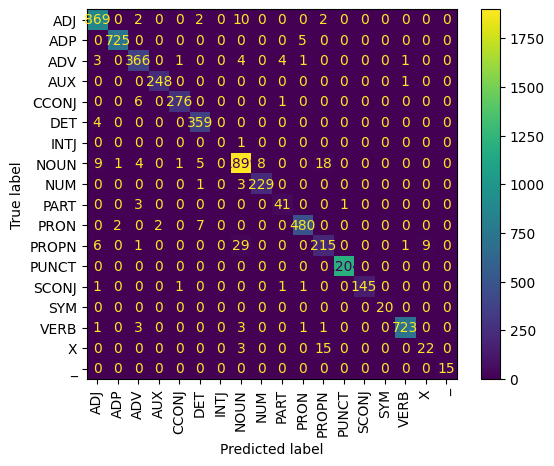

In [13]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()

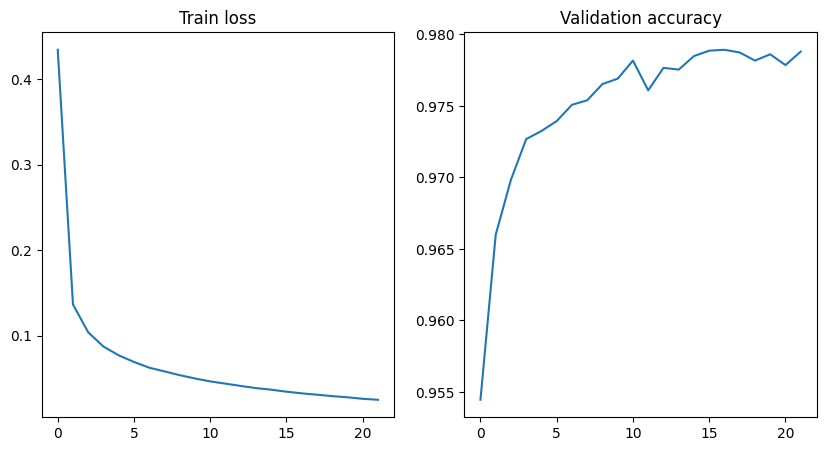

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(clf.loss_curve_)
ax1.set_title('Train loss')
ax2.plot(clf.validation_scores_)
ax2.set_title('Validation accuracy')
plt.show()